# Modelos LSTM para Gera√ß√£o de Receitas

In [ ]:
%pip install json
%pip install tensorflow
%pip install sklearn
%pip install numpy 
%pip install tqdm
%pip install matplotlib
%pip install tqdm

## Coleta de Dados via Web Scraping

Realiza web scraping de receitas do site Panelinha.

Etapas:
1. Coleta todos os links de receitas percorrendo at√© 235 p√°ginas de resultados.
2. Para cada link, extrai t√≠tulo, ingredientes e modo de preparo da receita.
3. Utiliza Selenium WebDriver (modo headless) para lidar com o carregamento din√¢mico via JavaScript.
4. Usa BeautifulSoup para fazer o parsing do HTML.
5. Gera o arquivo corpus.txt no formato JSONL (um JSON por linha) com todas as receitas coletadas.

In [ ]:
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from urllib.parse import urljoin
from selenium import webdriver
from bs4 import BeautifulSoup
import json
import time
import re

# Configura√ß√µes base do site
BASE_URL = "https://panelinha.com.br"
SEARCH_URL = "https://panelinha.com.br/busca?query=&page={}&menu%5Bpage_type%5D=Receitas"

def init_driver():
    """Inicializa o driver do Selenium com configura√ß√µes headless"""
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    return driver

def get_recipe_links(driver):
    """Coleta links de receitas de todas as p√°ginas de busca"""
    links = []
    page = 1
    while page <= 235:
        url = SEARCH_URL.format(page)
        print(f"Acessando p√°gina {page}: {url}")
        driver.get(url)
        time.sleep(3)  # Aguarda carregamento do JavaScript

        soup = BeautifulSoup(driver.page_source, "html.parser")
        container = soup.select_one(".hitsContainer2C .ais-Hits ol")
        if not container:
            print(f"Nenhum resultado encontrado na p√°gina {page}, encerrando coleta.")
            break

        for a in container.select("li a[href]"):
            recipe_url = urljoin(BASE_URL, a["href"])
            # Filtra apenas URLs v√°lidas de receitas
            if re.match(r"^https://panelinha\.com\.br/receita/.+", recipe_url):
                if recipe_url not in links:
                    links.append(recipe_url)

        page += 1

    return links

def scrape_recipe(driver, url):
    """Extrai dados de uma receita individual"""
    print(f"Coletando receita: {url}")
    driver.get(url)
    time.sleep(2)  # Aguarda carregamento da p√°gina

    soup = BeautifulSoup(driver.page_source, "html.parser")

    # Extrai t√≠tulo da receita
    titulo = soup.find("h1").get_text(strip=True).lower() if soup.find("h1") else ""

    # Extrai lista de ingredientes
    ingredientes = []
    h5_ing = soup.find("h5", string=lambda x: x and "Ingredientes" in x)
    if h5_ing:
        ul = h5_ing.find_next_sibling("ul")
        if ul:
            ingredientes = [li.get_text(strip=True).lower() for li in ul.find_all("li")]

    # Extrai modo de preparo
    preparo = []
    h5_prep = soup.find("h5", string=lambda x: x and "Modo de preparo" in x)
    if h5_prep:
        ol = h5_prep.find_next_sibling("ol")
        if ol:
            preparo = [li.get_text(strip=True).lower() for li in ol.find_all("li")]

    return {
        "url": url.lower(),
        "titulo": titulo,
        "ingredientes": ingredientes,
        "preparo": preparo
    }

if __name__ == "__main__":
    driver = init_driver()

    try:
        # Coleta links de todas as receitas
        receitas_links = get_recipe_links(driver)
        print("Total de receitas encontradas:", len(receitas_links))

        # Extrai dados de cada receita
        corpus = []
        for link in receitas_links:
            dados = scrape_recipe(driver, link)
            if dados:
                corpus.append(dados)

        # Salva corpus em arquivo JSONL
        with open("corpus.txt", "w", encoding="utf-8") as f:
            for item in corpus:
                f.write(json.dumps(item, ensure_ascii=False) + "\n")

        print("Corpus salvo em corpus.txt")
    finally:
        driver.quit()

## Pr√©-processamento e Tokeniza√ß√£o do Corpus

Pr√©-processa o corpus de receitas coletado via web scraping.

Etapas:
1. Carrega e organiza os dados textuais, unindo t√≠tulo, ingredientes e modo de preparo.
2. Aplica tokeniza√ß√£o com o Tokenizer do Keras, incluindo tratamento para palavras fora do vocabul√°rio (OOV).
3. Divide o corpus em treino (80%), valida√ß√£o (10%) e teste (10%) de forma estratificada.
4. Define uma semente aleat√≥ria para garantir reprodutibilidade.
5. Salva os objetos processados para uso nas pr√≥ximas etapas do projeto.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import json
import os

CORPUS_FILE = "corpus.txt"

# Verifica√ß√£o de integridade do arquivo de corpus
if not os.path.exists(CORPUS_FILE):
    print(f"Erro: O arquivo '{CORPUS_FILE}' n√£o foi encontrado no diret√≥rio.")
    print("Certifique-se de que o arquivo de corpus est√° dispon√≠vel antes de executar o processamento.")
else:
    print(f"Arquivo '{CORPUS_FILE}' localizado. Iniciando pr√©-processamento...")
    
    # Configura√ß√µes de processamento
    OOV_TOKEN = "<OOV>"
    TEST_SIZE = 0.2
    VAL_SIZE = 0.5  # 50% dos dados de teste alocados para valida√ß√£o
    NUM_WORDS = None  # Utilizar vocabul√°rio completo

    # Carregamento e estrutura√ß√£o dos textos
    corpus_texts = []
    with open(CORPUS_FILE, "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line)
            # Combina t√≠tulo, ingredientes e modo de preparo em documento √∫nico
            texto = " ".join([data["titulo"]] + data["ingredientes"] + data["preparo"])
            corpus_texts.append(texto)

    print(f"Total de receitas carregadas do corpus: {len(corpus_texts)}")

    # Tokeniza√ß√£o do vocabul√°rio
    tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV_TOKEN)
    tokenizer.fit_on_texts(corpus_texts)

    # Convers√£o para representa√ß√£o sequencial num√©rica
    sequences = tokenizer.texts_to_sequences(corpus_texts)

    word_index = tokenizer.word_index
    print(f"Tamanho do vocabul√°rio identificado: {len(word_index)}")

    # Divis√£o em conjuntos de treino, valida√ß√£o e teste
    train_seq, temp_seq = train_test_split(sequences, test_size=TEST_SIZE, random_state=42)
    val_seq, test_seq = train_test_split(temp_seq, test_size=VAL_SIZE, random_state=42)

    print("-" * 30)
    print(f"Dados de Treino:   {len(train_seq)} receitas")
    print(f"Dados de Valida√ß√£o: {len(val_seq)} receitas")
    print(f"Dados de Teste:     {len(test_seq)} receitas")
    print("-" * 30)

    # Persist√™ncia dos objetos processados
    with open("tokenizer.pkl", "wb") as f:
        pickle.dump(tokenizer, f)

    np.save("train_seq.npy", np.array(train_seq, dtype=object))
    np.save("val_seq.npy", np.array(val_seq, dtype=object))
    np.save("test_seq.npy", np.array(test_seq, dtype=object))

    print("Pr√©-processamento conclu√≠do com sucesso")
    print("Arquivos gerados: tokenizer.pkl, train_seq.npy, val_seq.npy, test_seq.npy")

Arquivo 'C:\Users\Gustavo\Documents\nlp-pt-lstm-gen\src\corpus\corpus.txt' encontrado. Iniciando o pr√©-processamento...
Total de receitas carregadas do corpus: 2787
Tamanho do vocabul√°rio encontrado: 4055
------------------------------
Dados de Treino:   2229 receitas
Dados de Valida√ß√£o: 279 receitas
Dados de Teste:     279 receitas
------------------------------
‚úÖ Pr√©-processamento conclu√≠do com sucesso!
Arquivos salvos: tokenizer.pkl, train_seq.npy, val_seq.npy, test_seq.npy


## Implementa√ß√£o e Treinamento do Modelo LSTM Baseline

Implementa e treina o modelo LSTM baseline para gera√ß√£o de texto em portugu√™s.

Etapas:
1. Prepara os dados sequenciais com padding e one-hot encoding.
2. Define a arquitetura do modelo com camadas de Embedding, LSTM e Densa.
3. Implementa a m√©trica personalizada de perplexidade.
4. Treina o modelo utilizando callbacks para salvar o melhor resultado e aplicar parada antecipada.
5. Avalia o modelo de forma quantitativa (perplexidade) e qualitativa (gera√ß√£o de texto com diferentes temperaturas).
6. Gera gr√°ficos de evolu√ß√£o das m√©tricas e salva todos os artefatos para an√°lise posterior.

Dados carregados com sucesso!
Tamanho do vocabul√°rio: 4056
Tamanho m√°ximo da sequ√™ncia: 271
Shape de X_train_pad: (172931, 271)
Shape de y_train_cat: (172931, 4056)


c:\Users\Gustavo\Documents\nlp-pt-lstm-gen\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_1 (Embedding)         ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)                   ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.1542 - loss: 5.3413 - perplexity: 411.1152

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1404s 1s/step - accuracy: 0.2171 - loss: 4.6281 - perplexity: 162.4668 - val_accuracy: 0.3353 - val_loss: 3.6052 - val_perplexity: 42.5427
Epoch 2/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.3505 - loss: 3.4732 - perplexity: 33.5408

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1431s 1s/step - accuracy: 0.3724 - loss: 3.3158 - perplexity: 28.8023 - val_accuracy: 0.4168 - val_loss: 2.9864 - val_perplexity: 23.2592
Epoch 3/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.4231 - loss: 2.9061 - perplexity: 18.7765

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1438s 1s/step - accuracy: 0.4309 - loss: 2.8363 - perplexity: 17.5244 - val_accuracy: 0.4531 - val_loss: 2.7013 - val_perplexity: 17.5570
Epoch 4/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.4559 - loss: 2.6001 - perplexity: 13.7554

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1408s 1s/step - accuracy: 0.4627 - loss: 2.5617 - perplexity: 13.2352 - val_accuracy: 0.4775 - val_loss: 2.5347 - val_perplexity: 14.8429
Epoch 5/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.4823 - loss: 2.3994 - perplexity: 11.2202

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1422s 1s/step - accuracy: 0.4859 - loss: 2.3785 - perplexity: 11.0018 - val_accuracy: 0.4907 - val_loss: 2.4371 - val_perplexity: 13.5167
Epoch 6/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.4991 - loss: 2.2564 - perplexity: 9.7322

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1483s 1s/step - accuracy: 0.5018 - loss: 2.2429 - perplexity: 9.6046 - val_accuracy: 0.5013 - val_loss: 2.3717 - val_perplexity: 12.6630
Epoch 7/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5135 - loss: 2.1435 - perplexity: 8.6831

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1520s 1s/step - accuracy: 0.5138 - loss: 2.1418 - perplexity: 8.6739 - val_accuracy: 0.5106 - val_loss: 2.3312 - val_perplexity: 12.0884
Epoch 8/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5217 - loss: 2.0564 - perplexity: 7.9491

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1560s 1s/step - accuracy: 0.5237 - loss: 2.0561 - perplexity: 7.9915 - val_accuracy: 0.5188 - val_loss: 2.2992 - val_perplexity: 11.6911
Epoch 9/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5350 - loss: 1.9782 - perplexity: 7.3574

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1594s 1s/step - accuracy: 0.5352 - loss: 1.9864 - perplexity: 7.4228 - val_accuracy: 0.5238 - val_loss: 2.2778 - val_perplexity: 11.3444
Epoch 10/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5403 - loss: 1.9239 - perplexity: 6.9524

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1616s 1s/step - accuracy: 0.5418 - loss: 1.9265 - perplexity: 6.9715 - val_accuracy: 0.5273 - val_loss: 2.2642 - val_perplexity: 11.1704
Epoch 11/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5509 - loss: 1.8653 - perplexity: 6.5553

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1613s 1s/step - accuracy: 0.5489 - loss: 1.8747 - perplexity: 6.6191 - val_accuracy: 0.5312 - val_loss: 2.2487 - val_perplexity: 10.9346
Epoch 12/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5602 - loss: 1.8139 - perplexity: 6.2282

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1611s 1s/step - accuracy: 0.5574 - loss: 1.8262 - perplexity: 6.3209 - val_accuracy: 0.5325 - val_loss: 2.2443 - val_perplexity: 10.8885
Epoch 13/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5659 - loss: 1.7705 - perplexity: 5.9610

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1606s 1s/step - accuracy: 0.5627 - loss: 1.7864 - perplexity: 6.0549 - val_accuracy: 0.5370 - val_loss: 2.2369 - val_perplexity: 10.7576
Epoch 14/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5698 - loss: 1.7346 - perplexity: 5.7475

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1615s 1s/step - accuracy: 0.5677 - loss: 1.7493 - perplexity: 5.8352 - val_accuracy: 0.5358 - val_loss: 2.2305 - val_perplexity: 10.5890
Epoch 15/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5737 - loss: 1.7085 - perplexity: 5.5968

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1627s 1s/step - accuracy: 0.5738 - loss: 1.7154 - perplexity: 5.6361 - val_accuracy: 0.5412 - val_loss: 2.2271 - val_perplexity: 10.5592
Epoch 16/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5809 - loss: 1.6697 - perplexity: 5.3858

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1647s 1s/step - accuracy: 0.5778 - loss: 1.6833 - perplexity: 5.4641 - val_accuracy: 0.5405 - val_loss: 2.2266 - val_perplexity: 10.5114
Epoch 17/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5883 - loss: 1.6329 - perplexity: 5.1838

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1679s 1s/step - accuracy: 0.5831 - loss: 1.6546 - perplexity: 5.3068 - val_accuracy: 0.5433 - val_loss: 2.2227 - val_perplexity: 10.4754
Epoch 18/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1663s 1s/step - accuracy: 0.5877 - loss: 1.6275 - perplexity: 5.1642 - val_accuracy: 0.5458 - val_loss: 2.2244 - val_perplexity: 10.4799
Epoch 19/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5953 - loss: 1.5922 - perplexity: 4.9799

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1698s 1s/step - accuracy: 0.5912 - loss: 1.6052 - perplexity: 5.0446 - val_accuracy: 0.5493 - val_loss: 2.2219 - val_perplexity: 10.4711
Epoch 20/20
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5985 - loss: 1.5663 - perplexity: 4.8484

1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1690s 1s/step - accuracy: 0.5962 - loss: 1.5816 - perplexity: 4.9409 - val_accuracy: 0.5475 - val_loss: 2.2195 - val_perplexity: 10.3862
Treinamento conclu√≠do!
Perplexidade no TREINO: 4.09
Perplexidade na VALIDA√á√ÉO: 8.43

TEXTO SEMENTE: 'o primeiro passo √© cortar a cebola'

--- GERANDO TEXTO COM TEMPERATURA 0.7 ---
o primeiro passo √© cortar a cebola 1 ma√ßo de couve 1 cebola 1 dente de alho ¬Ω x√≠cara ch√° de √°gua 1 colher sopa de caldo de lim√£o sal e pimenta do reino mo√≠da na hora a gosto lave seque e corte a cebola em meias
------------------------------------------------

--- GERANDO TEXTO COM TEMPERATURA 1.0 ---
o primeiro passo √© cortar a cebola 2 batatas 2 mandioquinhas batatas baroas cerca de 500 g 2 dentes de alho 1 x√≠cara ch√° de damasco seco em conserva ¬º de x√≠cara ch√° de vinho branco 1 cebola 1 cenoura ¬Ω x√≠cara ch√° de cogumelo ‚Öì de
------------------------------------------------

--- GE

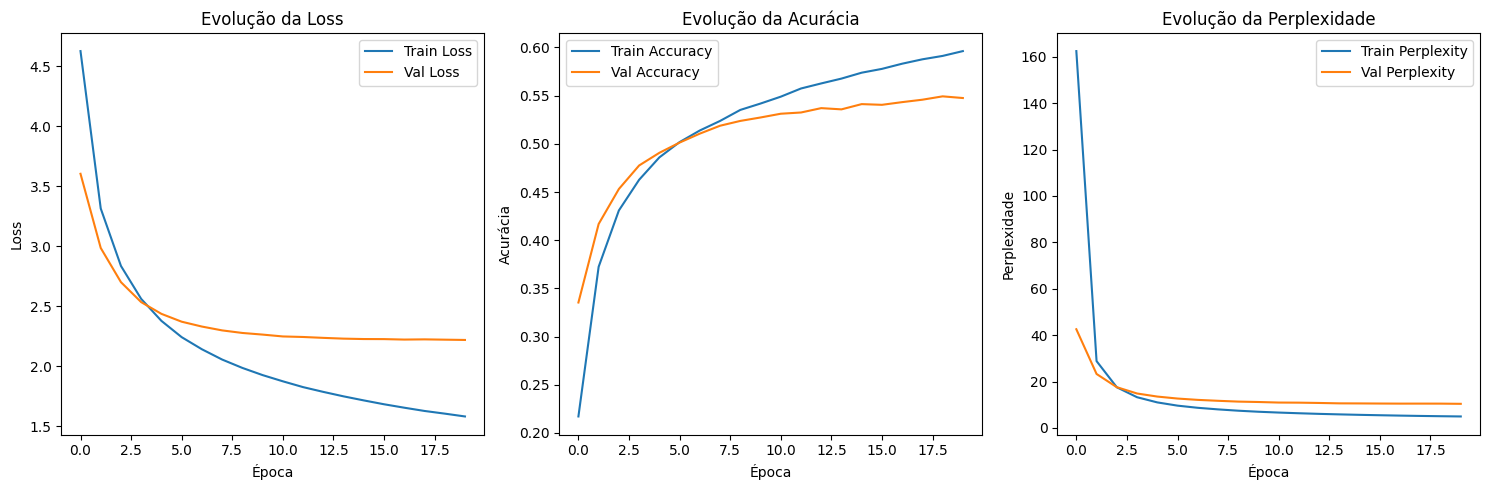


üíæ Salvando modelo e m√©tricas finais...


TypeError: Object of type float32 is not JSON serializable

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import json
import os

# Verifica√ß√£o de pr√©-requisitos
required_files = ["tokenizer.pkl", "train_seq.npy", "val_seq.npy"]
files_exist = all(os.path.exists(f) for f in required_files)

if not files_exist:
    print("Arquivos de pr√©-processamento n√£o encontrados.")
    print("Execute primeiro o c√≥digo de pr√©-processamento.")
else:
    # Carregamento dos dados pr√©-processados
    with open("tokenizer.pkl", "rb") as f:
        tokenizer = pickle.load(f)

    train_seq = np.load("train_seq.npy", allow_pickle=True)
    val_seq = np.load("val_seq.npy", allow_pickle=True)

    print("Dados carregados com sucesso")

    # Prepara√ß√£o dos dados para o modelo
    vocab_size = len(tokenizer.word_index) + 1

    def create_sequences(sequences):
        """Cria sequ√™ncias de entrada e sa√≠da para treinamento do modelo"""
        X, y = [], []
        for seq in sequences:
            for i in range(1, len(seq)):
                n_gram_sequence = seq[:i+1]
                X.append(n_gram_sequence[:-1])
                y.append(n_gram_sequence[-1])
        return X, y

    X_train, y_train = create_sequences(train_seq)
    X_val, y_val = create_sequences(val_seq)

    # Aplica√ß√£o de padding para sequ√™ncias de tamanho fixo
    max_sequence_len = max([len(x) for x in X_train])
    X_train_pad = pad_sequences(X_train, maxlen=max_sequence_len, padding='pre')
    X_val_pad = pad_sequences(X_val, maxlen=max_sequence_len, padding='pre')

    # Codifica√ß√£o one-hot dos r√≥tulos
    y_train_cat = to_categorical(y_train, num_classes=vocab_size)
    y_val_cat = to_categorical(y_val, num_classes=vocab_size)

    print(f"Tamanho do vocabul√°rio: {vocab_size}")
    print(f"Tamanho m√°ximo da sequ√™ncia: {max_sequence_len}")
    print(f"Shape de X_train_pad: {X_train_pad.shape}")
    print(f"Shape de y_train_cat: {y_train_cat.shape}")

    # Defini√ß√£o das m√©tricas customizadas
    def perplexity(y_true, y_pred):
        """Calcula a perplexidade como m√©dia exponencial da entropia cruzada"""
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return tf.exp(tf.reduce_mean(cross_entropy))

    def calculate_dataset_perplexity(model, X_pad, y_cat, batch_size=128):
        """Calcula perplexidade em conjunto de dados completo"""
        predictions = model.predict(X_pad, batch_size=batch_size, verbose=0)
        predictions = np.clip(predictions, 1e-7, 1.0)
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_cat, predictions)
        return np.exp(np.mean(cross_entropy.numpy()))

    # Configura√ß√£o de hiperpar√¢metros
    EMBEDDING_DIM = 100
    LSTM_UNITS = 150
    EPOCHS = 20
    BATCH_SIZE = 128

    # Defini√ß√£o da arquitetura do modelo
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_sequence_len),
        LSTM(LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2),
        Dense(vocab_size, activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy', perplexity]
    )

    model.summary()

    # Configura√ß√£o de callbacks
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        "best_baseline_model.h5",
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
    
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_loss'
    )

    # Execu√ß√£o do treinamento
    history = model.fit(
        X_train_pad, y_train_cat,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_pad, y_val_cat),
        callbacks=[checkpoint_cb, early_stopping_cb],
        verbose=1
    )

    print("Treinamento conclu√≠do")

    # Avalia√ß√£o quantitativa do modelo
    train_perplexity = calculate_dataset_perplexity(model, X_train_pad, y_train_cat)
    val_perplexity = calculate_dataset_perplexity(model, X_val_pad, y_val_cat)
    
    print(f"Perplexidade no Treino: {train_perplexity:.2f}")
    print(f"Perplexidade na Valida√ß√£o: {val_perplexity:.2f}")

    # Fun√ß√£o para gera√ß√£o de texto
    def safe_generate_text(seed_text, num_words_to_generate, model, tokenizer, max_sequence_len, temperature=1.0):
        """Gera texto sequencial com controle de temperatura e tratamento de erros"""
        generated_text = seed_text.lower()
        
        for _ in range(num_words_to_generate):
            token_list = tokenizer.texts_to_sequences([generated_text])[0]
            
            if len(token_list) == 0:
                break
                
            padded_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
            
            try:
                preds = model.predict(padded_list, verbose=0)[0]
                preds = np.clip(preds, 1e-7, 1.0)
                
                if temperature > 0:
                    preds = np.log(preds) / temperature
                    exp_preds = np.exp(preds)
                    preds = exp_preds / np.sum(exp_preds)
                
                predicted_index = np.random.choice(len(preds), p=preds)
                output_word = tokenizer.index_word.get(predicted_index, "")
                
                if not output_word or output_word == "<OOV>":
                    break
                    
                generated_text += " " + output_word
                
            except Exception as e:
                print(f"Erro na gera√ß√£o: {e}")
                break
                
        return generated_text

    # Gera√ß√£o de amostras de texto
    seed_text = "o primeiro passo √© cortar a cebola"

    print("\n" + "="*60)
    print(f"Texto Semente: '{seed_text}'")
    print("="*60)

    for temp in [0.7, 1.0, 1.3]:
        print(f"\n--- Gerando Texto com Temperatura {temp} ---")
        generated_recipe = safe_generate_text(
            seed_text, 40, model, tokenizer, max_sequence_len, temperature=temp
        )
        print(generated_recipe)
        print("-" * 50)

    # Visualiza√ß√£o das m√©tricas de treinamento
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Perda Treino')
    plt.plot(history.history['val_loss'], label='Perda Valida√ß√£o')
    plt.title('Evolu√ß√£o da Fun√ß√£o de Perda')
    plt.xlabel('√âpoca')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Acur√°cia Treino')
    plt.plot(history.history['val_accuracy'], label='Acur√°cia Valida√ß√£o')
    plt.title('Evolu√ß√£o da Acur√°cia')
    plt.xlabel('√âpoca')
    plt.ylabel('Acur√°cia')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history.history['perplexity'], label='Perplexidade Treino')
    plt.plot(history.history['val_perplexity'], label='Perplexidade Valida√ß√£o')
    plt.title('Evolu√ß√£o da Perplexidade')
    plt.xlabel('√âpoca')
    plt.ylabel('Perplexidade')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics_baseline.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Persist√™ncia dos resultados
    model.save("baseline_lstm_model.h5")
    
    with open("training_history.pkl", "wb") as f:
        pickle.dump(history.history, f)
    
    final_metrics = {
        'final_train_perplexity': float(train_perplexity),
        'final_val_perplexity': float(val_perplexity),
        'final_train_accuracy': float(history.history['accuracy'][-1]),
        'final_val_accuracy': float(history.history['val_accuracy'][-1]),
        'vocab_size': vocab_size,
        'max_sequence_len': max_sequence_len
    }
    
    with open("baseline_metrics.json", "w") as f:
        json.dump(final_metrics, f, indent=2)
    
    print("Modelo baseline finalizado e artefatos salvos")
    print(f"M√©tricas finais - Treino: {train_perplexity:.2f}, Valida√ß√£o: {val_perplexity:.2f}")

## Implementa√ß√£o da Variante com Embeddings FastText Pr√©-treinados

Implementa a variante do modelo LSTM com embeddings FastText pr√©-treinados em portugu√™s.

Etapas:
1. Realiza o download autom√°tico dos vetores de embeddings FastText.
2. Cria uma matriz de embedding compat√≠vel com o vocabul√°rio do corpus.
3. Adota um treinamento em duas fases:
   - Fase 1: embeddings congelados para aproveitar o conhecimento lingu√≠stico pr√©vio.
   - Fase 2: fine-tuning com embeddings ajust√°veis ao dom√≠nio de receitas.
4. Compara o desempenho entre embeddings pr√©-treinados e embeddings treinados do zero na gera√ß√£o de texto.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import requests
import shutil
import pickle
import gzip
import json
import os

def download_fasttext_ptbr():
    """
    Realiza download dos embeddings FastText em portugu√™s
    Retorna o caminho para o arquivo extra√≠do
    """
    fasttext_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.pt.300.vec.gz"
    local_path = "cc.pt.300.vec.gz"
    extracted_path = "cc.pt.300.vec"
    
    if not os.path.exists(extracted_path):
        # Download do arquivo com barra de progresso
        response = requests.get(fasttext_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        
        with open(local_path, 'wb') as f, tqdm(
            desc="Download FastText",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                size = f.write(data)
                bar.update(size)
        
        # Extra√ß√£o do arquivo compactado
        with gzip.open(local_path, 'rb') as f_in:
            with open(extracted_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        
        # Limpeza do arquivo tempor√°rio
        os.remove(local_path)
        print("Download e extra√ß√£o do FastText conclu√≠dos")
    
    return extracted_path

def load_fasttext_embeddings(embedding_path, word_index, embedding_dim=300):
    """
    Carrega embeddings FastText e constr√≥i matriz para o vocabul√°rio espec√≠fico
    Retorna matriz de embedding e taxa de cobertura
    """
    embeddings_index = {}
    
    # Leitura do arquivo de embeddings
    with open(embedding_path, 'r', encoding='utf-8') as f:
        next(f)  # Ignora linha de cabe√ßalho
        for line in tqdm(f, desc="Carregando embeddings"): 
            values = line.split()
            if len(values) < embedding_dim + 1:
                continue
            word = values[0]
            coefs = np.asarray(values[1:embedding_dim+1], dtype='float32')
            embeddings_index[word] = coefs
    
    print(f"Embeddings carregados: {len(embeddings_index)} palavras")
    
    # Constru√ß√£o da matriz de embedding
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    words_found = 0
    
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            words_found += 1
        else:
            # Inicializa√ß√£o aleat√≥ria para palavras n√£o encontradas
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))
    
    coverage = words_found / len(word_index) * 100
    print(f"Cobertura do vocabul√°rio: {words_found}/{len(word_index)} ({coverage:.2f}%)")
    
    return embedding_matrix, coverage

# Carregamento dos dados pr√©-processados
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

train_seq = np.load("train_seq.npy", allow_pickle=True)
val_seq = np.load("val_seq.npy", allow_pickle=True)
test_seq = np.load("test_seq.npy", allow_pickle=True)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

print(f"Dados carregados: Vocabul√°rio={vocab_size}")

# Prepara√ß√£o das sequ√™ncias de treinamento
def create_sequences(sequences):
    """Converte sequ√™ncias em pares input-output para treinamento"""
    X, y = [], []
    for seq in sequences:
        for i in range(1, len(seq)):
            n_gram_sequence = seq[:i+1]
            X.append(n_gram_sequence[:-1])
            y.append(n_gram_sequence[-1])
    return X, y

X_train, y_train = create_sequences(train_seq)
X_val, y_val = create_sequences(val_seq)

max_sequence_len = max([len(x) for x in X_train])
X_train_pad = pad_sequences(X_train, maxlen=max_sequence_len, padding='pre')
X_val_pad = pad_sequences(X_val, maxlen=max_sequence_len, padding='pre')

y_train_cat = to_categorical(y_train, num_classes=vocab_size)
y_val_cat = to_categorical(y_val, num_classes=vocab_size)

print(f"Dados preparados: X_train {X_train_pad.shape}, X_val {X_val_pad.shape}")

# Download e carregamento dos embeddings FastText
embedding_path = download_fasttext_ptbr()
embedding_matrix, coverage = load_fasttext_embeddings(embedding_path, word_index)

# Defini√ß√£o da m√©trica de perplexidade
def perplexity(y_true, y_pred):
    """Calcula perplexidade como m√©trica de avalia√ß√£o"""
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return tf.exp(tf.reduce_mean(cross_entropy))

# Configura√ß√£o de hiperpar√¢metros
EMBEDDING_DIM = 300  # Dimens√£o dos embeddings FastText
LSTM_UNITS = 150
EPOCHS_PRETRAIN = 10   # Fase com embeddings congelados
EPOCHS_FINETUNE = 10   # Fase de fine-tuning
BATCH_SIZE = 128

# Constru√ß√£o do modelo com embeddings pr√©-treinados
fasttext_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        input_length=max_sequence_len,
        weights=[embedding_matrix],
        trainable=False  # Embeddings inicialmente congelados
    ),
    LSTM(LSTM_UNITS, dropout=0.2, recurrent_dropout=0.2),
    Dense(vocab_size, activation='softmax')
])

fasttext_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', perplexity]
)

print("Modelo FastText criado - embeddings inicialmente congelados")
fasttext_model.summary()

# Fase 1: Treinamento com embeddings congelados
print("FASE 1: Treinamento com embeddings congelados")
history_phase1 = fasttext_model.fit(
    X_train_pad, y_train_cat,
    epochs=EPOCHS_PRETRAIN,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val_cat),
    verbose=1
)

# Fase 2: Fine-tuning dos embeddings
print("FASE 2: Fine-tuning - embeddings liberados para ajuste")

# Libera√ß√£o da camada de embedding para treinamento
fasttext_model.layers[0].trainable = True

# Recompila√ß√£o com taxa de aprendizado reduzida
fasttext_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy', perplexity]
)

history_phase2 = fasttext_model.fit(
    X_train_pad, y_train_cat,
    epochs=EPOCHS_FINETUNE,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_pad, y_val_cat),
    verbose=1
)

# Consolida√ß√£o dos hist√≥ricos de treinamento
full_history = {
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'perplexity': history_phase1.history['perplexity'] + history_phase2.history['perplexity'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'val_perplexity': history_phase1.history['val_perplexity'] + history_phase2.history['val_perplexity']
}

# Avalia√ß√£o da variante FastText
def calculate_dataset_perplexity(model, X_pad, y_cat, batch_size=128):
    """Calcula perplexidade em conjunto de dados completo"""
    predictions = model.predict(X_pad, batch_size=batch_size, verbose=0)
    predictions = np.clip(predictions, 1e-7, 1.0)
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_cat, predictions)
    return np.exp(np.mean(cross_entropy.numpy()))

fasttext_train_ppl = calculate_dataset_perplexity(fasttext_model, X_train_pad, y_train_cat)
fasttext_val_ppl = calculate_dataset_perplexity(fasttext_model, X_val_pad, y_val_cat)

print("M√©tricas da variante FastText:")
print(f"   Perplexidade Treino: {fasttext_train_ppl:.2f}")
print(f"   Perplexidade Valida√ß√£o: {fasttext_val_ppl:.2f}")
print(f"   Cobertura FastText: {coverage:.2f}%")

# Persist√™ncia do modelo e m√©tricas
fasttext_model.save("fasttext_variant_model.h5")

variant_metrics = {
    'fasttext_train_perplexity': float(fasttext_train_ppl),
    'fasttext_val_perplexity': float(fasttext_val_ppl),
    'fasttext_coverage': float(coverage),
    'final_val_accuracy': float(full_history['val_accuracy'][-1]),
    'embedding_dim': EMBEDDING_DIM,
    'training_phases': f"{EPOCHS_PRETRAIN}+{EPOCHS_FINETUNE} √©pocas"
}

with open("fasttext_variant_metrics.json", "w") as f:
    json.dump(variant_metrics, f, indent=2)

with open("fasttext_training_history.pkl", "wb") as f:
    pickle.dump(full_history, f)

print("Variante FastText salva com sucesso")

Dados carregados: Vocabul√°rio=4056
Dados preparados: X_train (172931, 271), X_val (21846, 271)


Download: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1.18G/1.18G [00:58<00:00, 21.7MB/s] 


Download e extra√ß√£o do FastText conclu√≠dos.


Lendo embeddings: 2000000it [01:47, 18586.20it/s]
c:\Users\Gustavo\Documents\nlp-pt-lstm-gen\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Embeddings carregados: 2000000 palavras
Cobertura do vocabul√°rio: 3759/4055 (92.70%)
Modelo FastText criado (embeddings congelados)


Model: "sequential_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_2 (Embedding)         ‚îÇ ?                      ‚îÇ     1,216,800 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_2 (LSTM)                   ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ ?                      ‚îÇ   0 (unbuilt) ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,216,800 (4.64 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,216,800 (4.64 MB)

FASE 1: Treinamento com embeddings CONGELADOS
Epoch 1/10
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2150s 2s/step - accuracy: 0.2203 - loss: 4.5981 - perplexity: 155.9881 - val_accuracy: 0.3273 - val_loss: 3.6359 - val_perplexity: 43.3531
Epoch 2/10
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2084s 2s/step - accuracy: 0.3478 - loss: 3.4094 - perplexity: 31.4688 - val_accuracy: 0.3957 - val_loss: 3.0690 - val_perplexity: 24.9796
Epoch 3/10
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2109s 2s/step - accuracy: 0.3974 - loss: 2.9726 - perplexity: 20.0541 - val_accuracy: 0.4320 - val_loss: 2.7789 - val_perplexity: 18.8297
Epoch 4/10
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2113s 2s/step - accuracy: 0.4280 - loss: 2.7185 - perplexity: 15.5250 - val_accuracy: 0.4536 - val_loss: 2.6138 - val_perplexity: 15.9466
Epoch 5/10
1352/1352 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

M√©tricas da variante FastText:
   Perplexidade TREINO: 5.27
   Perplexidade VALIDA√á√ÉO: 8.06
   Cobertura FastText: 92.70%
Variante FastText salva!


## An√°lise Comparativa Sistem√°tica: Baseline vs FastText

Compara o modelo LSTM baseline com a variante usando embeddings FastText pr√©-treinados.

Etapas:
1. Gera visualiza√ß√µes comparativas das m√©tricas de treinamento (perplexidade, acur√°cia e loss).
2. Realiza compara√ß√£o estat√≠stica dos resultados finais entre os modelos.
3. Avalia qualitativamente os modelos por meio da gera√ß√£o de texto com diferentes temperaturas.
4. Analisa o impacto dos embeddings pr√©-treinados no desempenho da gera√ß√£o de texto em portugu√™s, considerando aspectos quantitativos e qualitativos.

Compara√ß√£o Sistem√°tica: Modelo Baseline vs Variante FastText
Modelos e m√©tricas carregados com sucesso


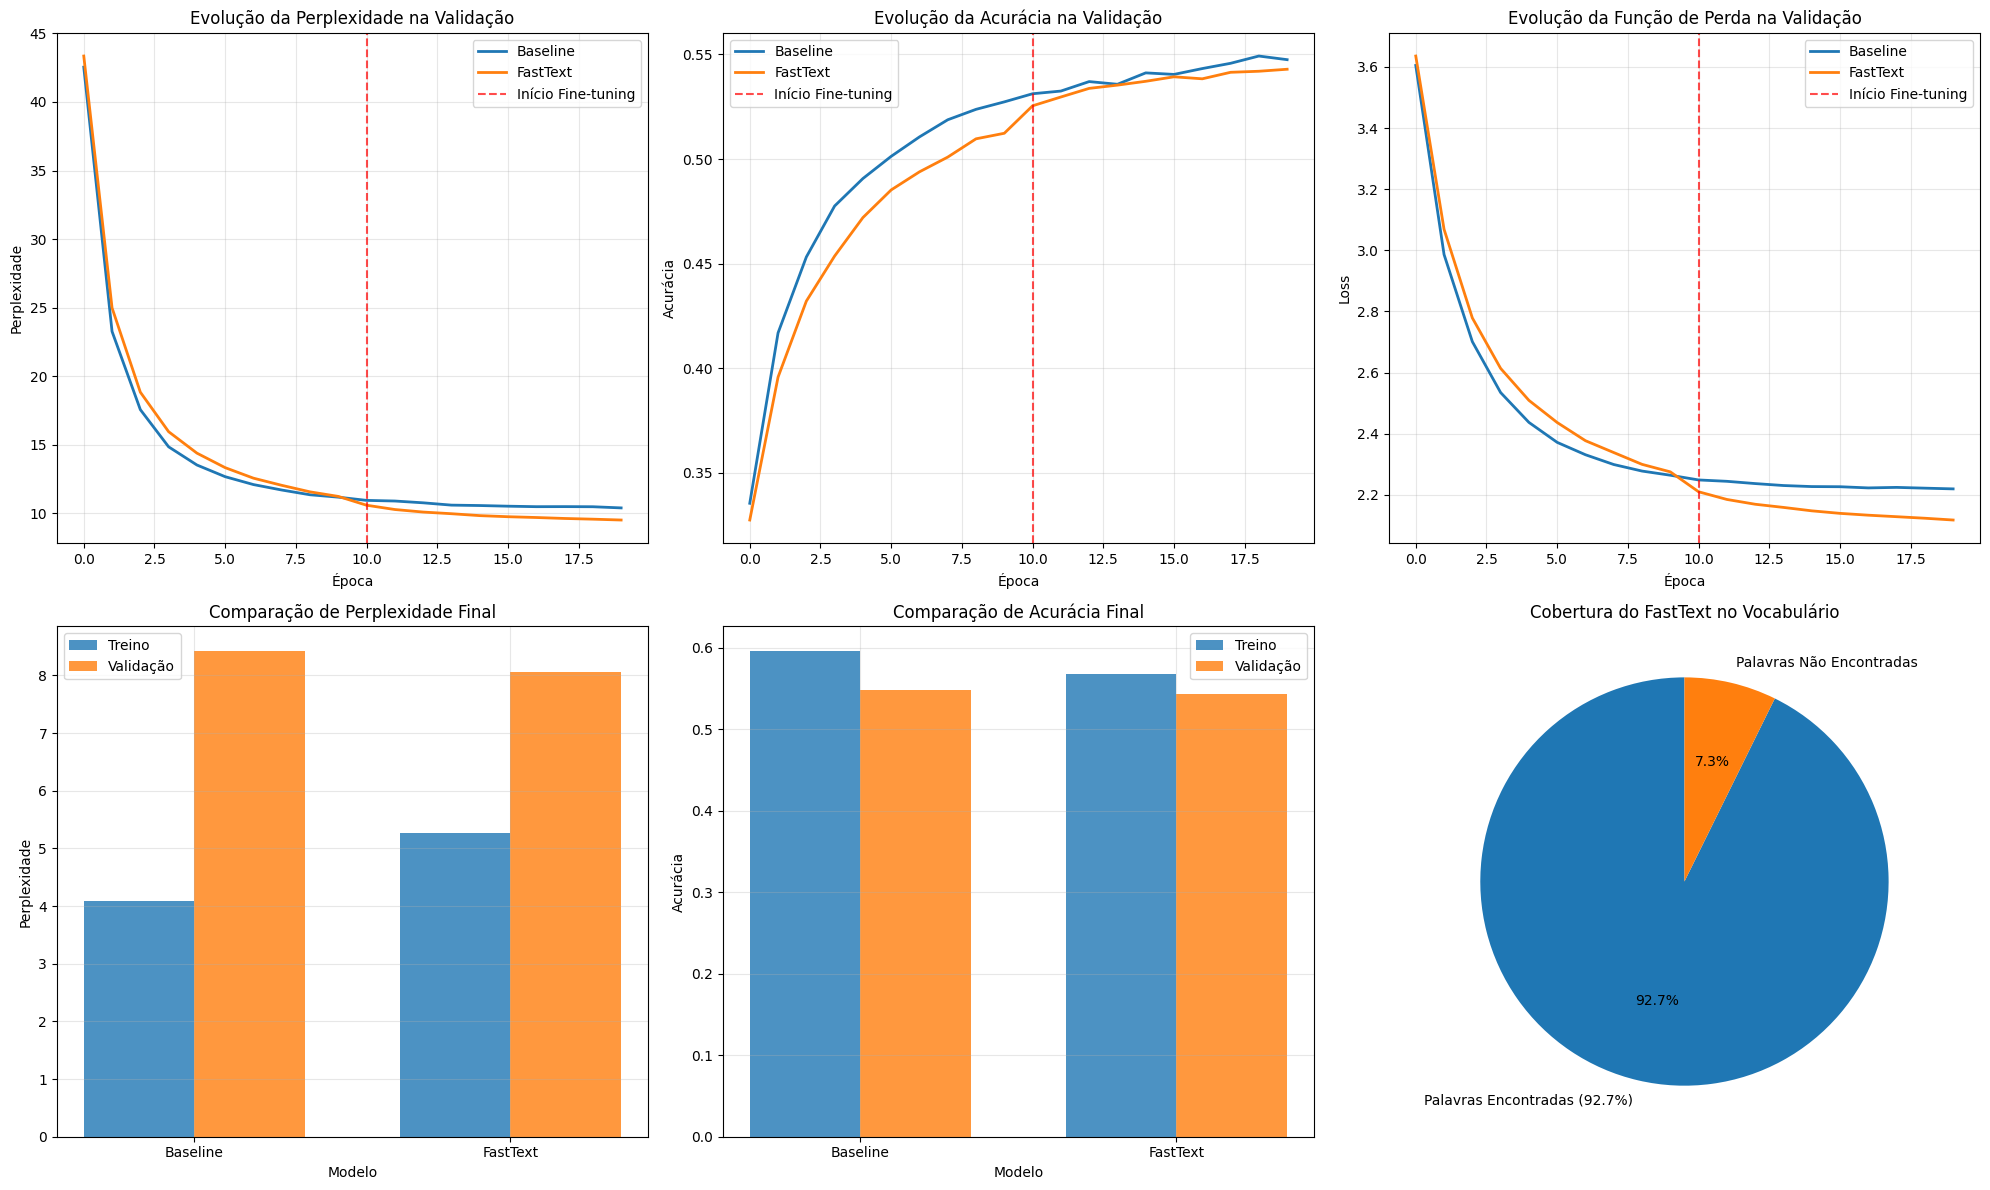

RESUMO COMPARATIVO DOS MODELOS
BASELINE (Embeddings Treinados do Zero):
  ‚Ä¢ Perplexidade Treino: 4.09
  ‚Ä¢ Perplexidade Valida√ß√£o: 8.43
  ‚Ä¢ Acur√°cia Final: 0.548

FASTTEXT (Embeddings Pr√©-treinados + Fine-tuning):
  ‚Ä¢ Perplexidade Treino: 5.27
  ‚Ä¢ Perplexidade Valida√ß√£o: 8.06
  ‚Ä¢ Acur√°cia Final: 0.543
  ‚Ä¢ Cobertura do Vocabul√°rio: 92.70%

AN√ÅLISE DE MELHORIAS:
  ‚Ä¢ Redu√ß√£o na Perplexidade de Valida√ß√£o: +4.39%
  ‚Ä¢ Redu√ß√£o no Overfitting: 1.55 pontos

COMPARA√á√ÉO DE TEXTO GERADO - TEMPERATURA 0.7

SEED 1: 'o primeiro passo √© cortar a cebola'
--------------------------------------------------
BASELINE:  o primeiro passo √© cortar a cebola 300 g de macarr√£o espaguete ou outra massa longa de grano duro 1 cebola 1 dente de alho ‚Öì de x√≠cara ch√° de azeite ¬Ω colher ch√° de pimenta s√≠ria ¬Ω x√≠cara ch√° de vinagre de vinho branco azeite andorinha
FASTTEXT:  o primeiro passo √© cortar a cebola caramelizada 2 bifes de frango com pele e osso cerca de 1 kg 1 x

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json

print("Compara√ß√£o Sistem√°tica: Modelo Baseline vs Variante FastText")

# Defini√ß√£o da fun√ß√£o de perplexidade para carregamento dos modelos
def perplexity(y_true, y_pred):
    """M√©trica de perplexidade para avalia√ß√£o dos modelos"""
    import tensorflow as tf
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return tf.exp(tf.reduce_mean(cross_entropy))

# Carregamento dos modelos treinados e m√©tricas
baseline_model = load_model("baseline_lstm_model.h5", custom_objects={'perplexity': perplexity})
fasttext_model = load_model("fasttext_variant_model.h5", custom_objects={'perplexity': perplexity})

with open("baseline_metrics.json", "r") as f:
    baseline_metrics = json.load(f)

with open("fasttext_variant_metrics.json", "r") as f:
    fasttext_metrics = json.load(f)

# Carregamento dos hist√≥ricos de treinamento
with open("training_history.pkl", "rb") as f:
    baseline_history = pickle.load(f)

with open("fasttext_training_history.pkl", "rb") as f:
    fasttext_history = pickle.load(f)

print("Modelos e m√©tricas carregados com sucesso")

# Visualiza√ß√£o comparativa das m√©tricas de treinamento
plt.figure(figsize=(20, 12))

# Evolu√ß√£o da perplexidade na valida√ß√£o
plt.subplot(2, 3, 1)
plt.plot(baseline_history['val_perplexity'], label='Baseline', linewidth=2)
plt.plot(fasttext_history['val_perplexity'], label='FastText', linewidth=2)
plt.axvline(x=10, color='red', linestyle='--', alpha=0.7, label='In√≠cio Fine-tuning')
plt.title('Evolu√ß√£o da Perplexidade na Valida√ß√£o')
plt.xlabel('√âpoca')
plt.ylabel('Perplexidade')
plt.legend()
plt.grid(True, alpha=0.3)

# Evolu√ß√£o da acur√°cia na valida√ß√£o
plt.subplot(2, 3, 2)
plt.plot(baseline_history['val_accuracy'], label='Baseline', linewidth=2)
plt.plot(fasttext_history['val_accuracy'], label='FastText', linewidth=2)
plt.axvline(x=10, color='red', linestyle='--', alpha=0.7, label='In√≠cio Fine-tuning')
plt.title('Evolu√ß√£o da Acur√°cia na Valida√ß√£o')
plt.xlabel('√âpoca')
plt.ylabel('Acur√°cia')
plt.legend()
plt.grid(True, alpha=0.3)

# Evolu√ß√£o da fun√ß√£o de perda na valida√ß√£o
plt.subplot(2, 3, 3)
plt.plot(baseline_history['val_loss'], label='Baseline', linewidth=2)
plt.plot(fasttext_history['val_loss'], label='FastText', linewidth=2)
plt.axvline(x=10, color='red', linestyle='--', alpha=0.7, label='In√≠cio Fine-tuning')
plt.title('Evolu√ß√£o da Fun√ß√£o de Perda na Valida√ß√£o')
plt.xlabel('√âpoca')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Compara√ß√£o de perplexidade final
plt.subplot(2, 3, 4)
models = ['Baseline', 'FastText']
ppl_train = [baseline_metrics['final_train_perplexity'], fasttext_metrics['fasttext_train_perplexity']]
ppl_val = [baseline_metrics['final_val_perplexity'], fasttext_metrics['fasttext_val_perplexity']]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, ppl_train, width, label='Treino', alpha=0.8)
plt.bar(x + width/2, ppl_val, width, label='Valida√ß√£o', alpha=0.8)
plt.title('Compara√ß√£o de Perplexidade Final')
plt.xlabel('Modelo')
plt.ylabel('Perplexidade')
plt.xticks(x, models)
plt.legend()
plt.grid(True, alpha=0.3)

# Compara√ß√£o de acur√°cia final
plt.subplot(2, 3, 5)
acc_train = [baseline_history['accuracy'][-1], fasttext_history['accuracy'][-1]]
acc_val = [baseline_history['val_accuracy'][-1], fasttext_history['val_accuracy'][-1]]

plt.bar(x - width/2, acc_train, width, label='Treino', alpha=0.8)
plt.bar(x + width/2, acc_val, width, label='Valida√ß√£o', alpha=0.8)
plt.title('Compara√ß√£o de Acur√°cia Final')
plt.xlabel('Modelo')
plt.ylabel('Acur√°cia')
plt.xticks(x, models)
plt.legend()
plt.grid(True, alpha=0.3)

# An√°lise de cobertura do FastText
plt.subplot(2, 3, 6)
coverage = fasttext_metrics['fasttext_coverage']
plt.pie([coverage, 100-coverage], 
        labels=[f'Palavras Encontradas ({coverage:.1f}%)', 'Palavras N√£o Encontradas'], 
        autopct='%1.1f%%', startangle=90)
plt.title('Cobertura do FastText no Vocabul√°rio')

plt.tight_layout()
plt.savefig('comparacao_baseline_vs_fasttext.png', dpi=300, bbox_inches='tight')
plt.show()

# An√°lise estat√≠stica comparativa
improvement_ppl = ((baseline_metrics['final_val_perplexity'] - fasttext_metrics['fasttext_val_perplexity']) / 
                   baseline_metrics['final_val_perplexity']) * 100

print("=" * 60)
print("RESUMO COMPARATIVO DOS MODELOS")
print("=" * 60)
print("BASELINE (Embeddings Treinados do Zero):")
print(f"  ‚Ä¢ Perplexidade Treino: {baseline_metrics['final_train_perplexity']:.2f}")
print(f"  ‚Ä¢ Perplexidade Valida√ß√£o: {baseline_metrics['final_val_perplexity']:.2f}")
print(f"  ‚Ä¢ Acur√°cia Final: {baseline_history['val_accuracy'][-1]:.3f}")

print("\nFASTTEXT (Embeddings Pr√©-treinados + Fine-tuning):")
print(f"  ‚Ä¢ Perplexidade Treino: {fasttext_metrics['fasttext_train_perplexity']:.2f}")
print(f"  ‚Ä¢ Perplexidade Valida√ß√£o: {fasttext_metrics['fasttext_val_perplexity']:.2f}")
print(f"  ‚Ä¢ Acur√°cia Final: {fasttext_history['val_accuracy'][-1]:.3f}")
print(f"  ‚Ä¢ Cobertura do Vocabul√°rio: {fasttext_metrics['fasttext_coverage']:.2f}%")

print("\nAN√ÅLISE DE MELHORIAS:")
print(f"  ‚Ä¢ Redu√ß√£o na Perplexidade de Valida√ß√£o: {improvement_ppl:+.2f}%")
print(f"  ‚Ä¢ Redu√ß√£o no Overfitting: {(baseline_metrics['final_val_perplexity'] - baseline_metrics['final_train_perplexity']) - (fasttext_metrics['fasttext_val_perplexity'] - fasttext_metrics['fasttext_train_perplexity']):.2f} pontos")

# Avalia√ß√£o qualitativa atrav√©s de gera√ß√£o de texto
def safe_generate_text(seed_text, num_words, model, tokenizer, max_len, temperature=1.0):
    """Gera texto sequencial com controle de temperatura e tratamento de erros"""
    generated_text = seed_text.lower()
    
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([generated_text])[0]
        if len(token_list) == 0:
            break
            
        padded_list = pad_sequences([token_list], maxlen=max_len, padding='pre')
        
        try:
            preds = model.predict(padded_list, verbose=0)[0]
            preds = np.clip(preds, 1e-7, 1.0)
            
            if temperature > 0:
                preds = np.log(preds) / temperature
                exp_preds = np.exp(preds)
                preds = exp_preds / np.sum(exp_preds)
            
            predicted_index = np.random.choice(len(preds), p=preds)
            output_word = tokenizer.index_word.get(predicted_index, "")
            
            if not output_word or output_word == "<OOV>":
                break
                
            generated_text += " " + output_word
            
        except Exception as e:
            break
            
    return generated_text

# Configura√ß√£o para gera√ß√£o comparativa
seed_texts = [
    "o primeiro passo √© cortar a cebola",
    "adicione o sal e a pimenta",
    "em uma panela coloque o √≥leo",
    "bata no liquidificador os ingredientes"
]

temperatures_required = [0.7, 1.0, 1.3]

# Carregamento do tokenizer e defini√ß√£o de par√¢metros
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

max_sequence_len = baseline_metrics['max_sequence_len']

# Gera√ß√£o comparativa para cada temperatura especificada
for temp in temperatures_required:
    print("\n" + "=" * 70)
    print(f"COMPARA√á√ÉO DE TEXTO GERADO - TEMPERATURA {temp}")
    print("=" * 70)

    for i, seed in enumerate(seed_texts, 1):
        print(f"\nSEED {i}: '{seed}'")
        print("-" * 50)
        
        baseline_text = safe_generate_text(seed, 40, baseline_model, tokenizer, max_sequence_len, temperature=temp)
        fasttext_text = safe_generate_text(seed, 40, fasttext_model, tokenizer, max_sequence_len, temperature=temp)
        
        print(f"BASELINE:  {baseline_text}")
        print(f"FASTTEXT:  {fasttext_text}")

# Gera√ß√£o do relat√≥rio comparativo final
comparison_report = {
    'baseline_metrics': baseline_metrics,
    'fasttext_metrics': fasttext_metrics,
    'improvement_percentage': improvement_ppl,
    'temperatures_analyzed': temperatures_required,
    'final_comparison': {
        'best_model': 'FastText' if fasttext_metrics['fasttext_val_perplexity'] < baseline_metrics['final_val_perplexity'] else 'Baseline',
        'reason': 'Menor perplexidade na valida√ß√£o indica melhor capacidade de generaliza√ß√£o'
    },
    'training_time_comparison': {
        'baseline_epochs': len(baseline_history['loss']),
        'fasttext_epochs': len(fasttext_history['loss']),
        'note': 'FastText incluiu fase adicional de fine-tuning'
    }
}

with open("comparison_report.json", "w") as f:
    json.dump(comparison_report, f, indent=2)

print("Relat√≥rio comparativo salvo em 'comparison_report.json'")